# Clustering Yelp Restaurants

**Part 1: To be completed INDIVIDUALLY and due on October 13 at 5pm.**

In this assignment, we will be working with the [Yelp dataset](https://www.yelp.com/dataset/challenge). Download the data from Round 10. You can find the format of the dataset [here](https://www.yelp.com/dataset/documentation/json).

From the Business Objects, let's try to find culinary districts in Las Vegas. These are characterized by closeness and similarity of restaurants. Use the "longitude" and "latitude" to cluster closeness. Use "categories" to cluster for similarity. You may want to use only a subset (15-20) of popular categories.

Note that the spatial coordinates and restaurant categories have different units of scale. Your results could be arbitrarily skewed if you don't incorporate some scaling.

Find clusters using the 3 different techniques we discussed in class: k-means++, hierarchical, and GMM. Explain your data representation and how you determined certain parameters (for example, the number of clusters in k-means++). **(30 pts)**

In [2]:
import json
import pandas as pd
from pandas import DataFrame
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import mixture
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import pairwise_distances as pairdist
from sklearn import preprocessing

In [3]:
# Getting top Categories to cluster for Similarity
cat_no=[]
file_open = open('business.json')
for i in file_open:
    cat = json.loads(i)
    if 'Restaurants' in cat['categories']:
        if cat['city'] =='Las Vegas':
            for j in cat['categories']:
                cat_no.append(j)


cat_no = (item.lower() for item in cat_no)
cat_nos= Counter(cat_no)


top_16=[]
for item in cat_nos.most_common(23):
    top_16.append(item[0])

top_16.remove('food') 
top_16.remove('nightlife')
top_16.remove('restaurants') 
top_16.remove('fast food')
top_16.remove('cafes')
top_16.remove('event planning & services')

top_16_df = DataFrame(top_16)
top_16_df.columns = ['Top Categories']
top_16

['american (traditional)',
 'mexican',
 'bars',
 'sandwiches',
 'pizza',
 'american (new)',
 'burgers',
 'chinese',
 'breakfast & brunch',
 'italian',
 'japanese',
 'seafood',
 'asian fusion',
 'sushi bars',
 'steakhouses',
 'chicken wings',
 'barbeque']

In [5]:
restaurant=[]
file_open = open('business.json')
for i in file_open:
    cat = json.loads(i)
    if 'Restaurants' in cat['categories']:
        if cat['city']=='Las Vegas':
            cat1=[]
            for j in cat['categories']:
                if j.lower() in top_16:
                    cat1.append(j)
            restaurant.append({'business_id':cat['business_id'],'longitude':cat['longitude'],'latitude':cat['latitude'],'categories':cat1})
        
restaurant_df=DataFrame(restaurant)
restaurant_df = restaurant_df[restaurant_df.astype(str)['categories'] != '[]']

latitudes = restaurant_df['latitude'].tolist()
longitudes = restaurant_df['longitude'].tolist()
latitudes = np.asarray(latitudes)
longitudes = np.asarray(longitudes)

restaurant_df.head(50)

,business_id,categories,latitude,longitude
0,LDMCrFlGIFUN6L-FEFgzWg,"[American (Traditional), Mexican]",36.196203,-115.116799
1,QTH_XGh4rWYdd0fTW-tUDw,[Mexican],36.112519,-115.242605
2,DiA78qPtp6rfRNdomzjBbw,[Chinese],36.083384,-115.033995
3,YTqtM2WFhcMZGeAGA08Cfg,"[Seafood, Mexican]",36.159363,-115.135949
4,Oto60yDwk1z72WmfWEYrjg,[Mexican],36.012191,-115.173993
6,1CP8aJa8ILlfM5deroar0Q,"[Chicken Wings, American (New)]",36.100251,-115.209894
7,TYGVaav4hWZioQlk9Ig78A,[Barbeque],36.151098,-115.159804
8,Wbi-x-1Nbn6LFCMOSN6F5Q,[Mexican],36.279467,-115.208013
9,W-3Sy3fy85mQdd0ZNFKIiw,"[Burgers, Bars, American (Traditional)]",36.125270,-115.243588
10,rihKlAiPgJa5XcpZ1h9-bw,[Chicken Wings],36.270700,-115.263000


In [6]:
conc = []
for i in restaurant_df['categories']:
    conc.append(''.join(map(str, i)))

vectorizer=CountVectorizer(vocabulary=top_16)
categ=vectorizer.fit_transform(conc)
categ = categ.toarray()

scaled_categ = preprocessing.scale(categ)

lat_long = restaurant_df[['latitude','longitude']].values
scaled_latlong =  preprocessing.scale(lat_long)

mat=np.concatenate((scaled_latlong,scaled_categ),axis=1)

C:\Users\kasim\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [44]:
print(categ)

[[0 1 0 ..., 0 0 0]
 [0 1 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 1 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


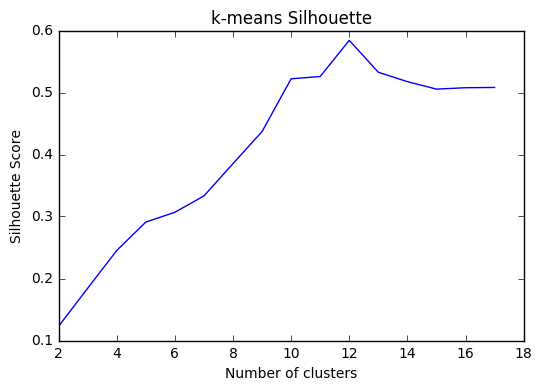

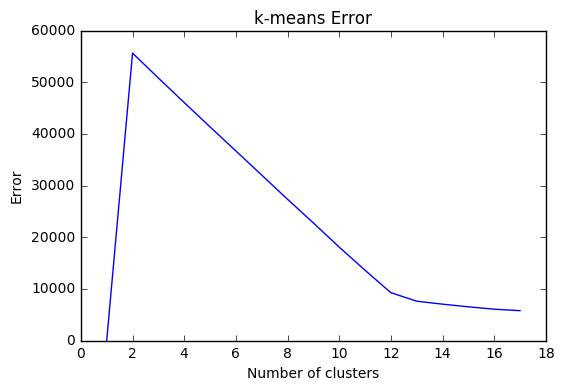

In [7]:
max_clusters = categ.shape[1]
s_k = np.zeros(max_clusters+1)
error = np.zeros(max_clusters+1)
error[0] = 0;
s_k[0] = 0;
s_k[1] = 0;
for k in range(2,max_clusters+1):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
    result = kmeans.fit_predict(mat)
    s_k[k] = silhouette_score(mat,kmeans.labels_,metric='euclidean')
    error[k] = kmeans.inertia_
plt.plot(range(2,len(s_k)),s_k[2:])
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('k-means Silhouette')
plt.show()
plt.title('k-means Error')
plt.plot(range(1,len(error)),error[1:])
plt.xlabel('Number of clusters')
dummy = plt.ylabel('Error')
plt.show()

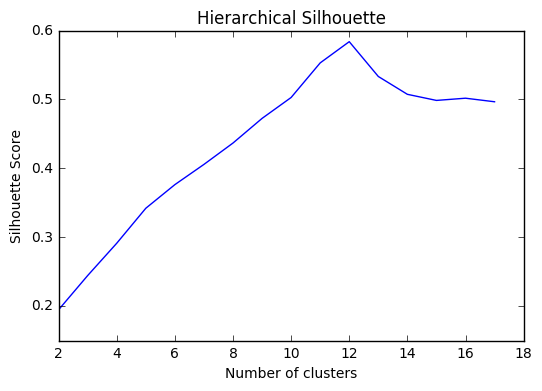

In [8]:
max_clusters = categ.shape[1]
s_k1 = np.zeros(max_clusters+1)
s_k1[0] = 0;
s_k1[1] = 0;
for k in range(2,max_clusters+1):
    hier = AgglomerativeClustering(n_clusters=k)
    result_1 = hier.fit_predict(mat)
    s_k1[k] = silhouette_score(mat,hier.labels_,metric='euclidean')
plt.plot(range(2,len(s_k1)),s_k1[2:])
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Hierarchical Silhouette')
plt.show()

C:\Users\kasim\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:57: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\kasim\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\kasim\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\kasim\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:75: DeprecationWarning: Fun

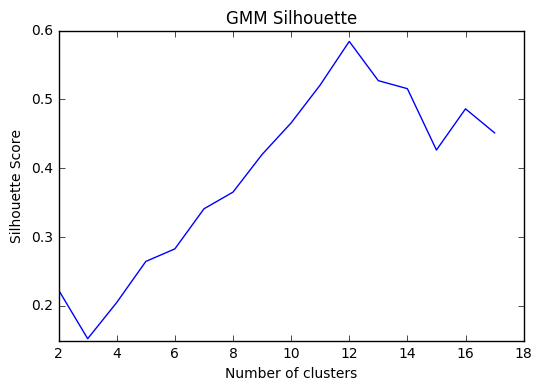

In [9]:
max_clusters = categ.shape[1]
s_k2 = np.zeros(max_clusters+1)
s_k2[0] = 0;
s_k2[1] = 0;
for k in range(2,max_clusters+1):
    Gmm = mixture.GMM(n_components=k, covariance_type='spherical')
    result_2 = Gmm.fit_predict(mat)
    s_k2[k] = silhouette_score(mat,result_2)
plt.plot(range(2,len(s_k2)),s_k2[2:])
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('GMM Silhouette')
plt.show()

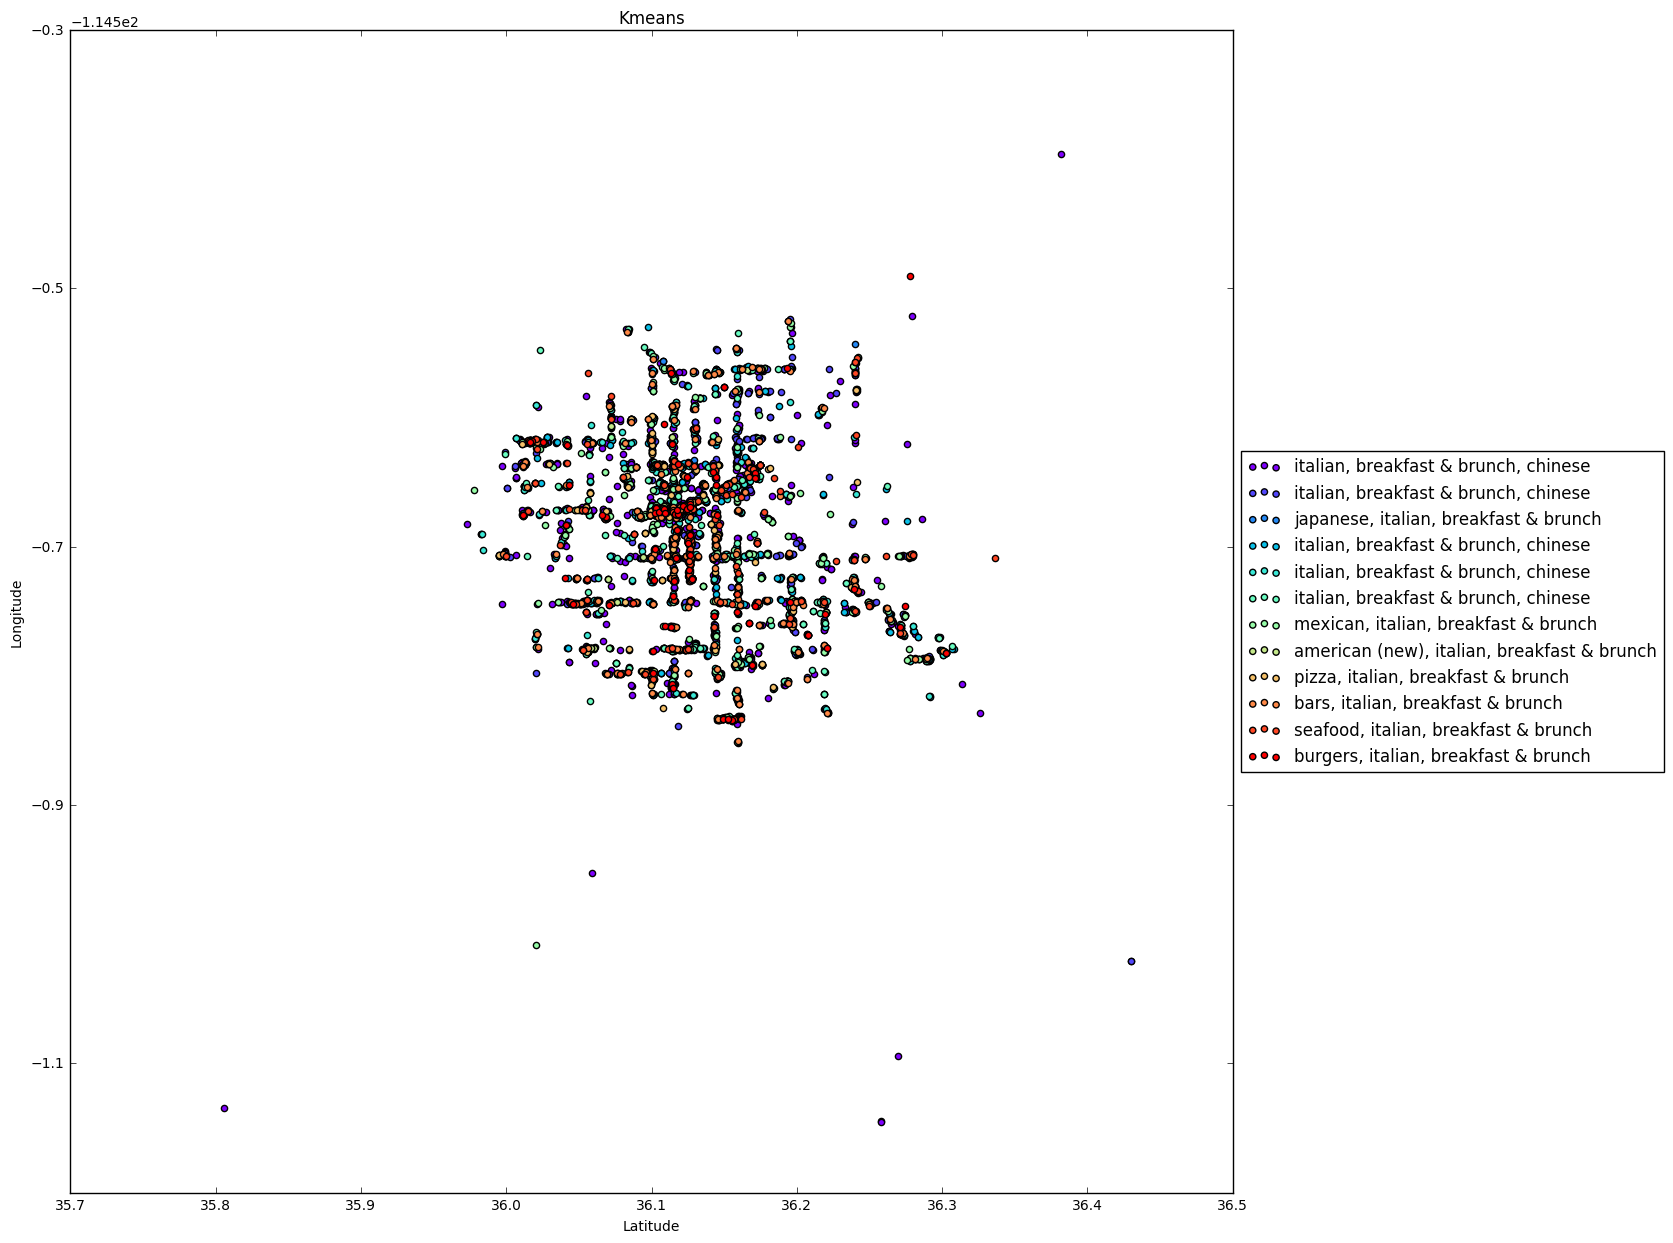

In [10]:
#Using the Silhouete Score 12 clusters is the best choice for clustering
K = 12

kmeans = KMeans(init='k-means++', n_clusters=K, max_iter=300)
result = kmeans.fit_predict(mat)
asc_centroids=kmeans.cluster_centers_[:,-K:].argsort()[:,::-1]
fig1=plt.figure(figsize=(15,15))
colors = cm.rainbow(np.linspace(0, 1, K))
for k in range(K):
    plt.scatter(latitudes[result==k],longitudes[result==k],c=colors[k,:],
                label=top_16[asc_centroids[k,0]]+', '+top_16[asc_centroids[k,1]]+', '+ top_16[asc_centroids[k,2]]) 

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  
plt.title('Kmeans')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

Each cluster's representative is labeled by their coordinates, the higher number in a category means the cluster representative is more likely to belongs to that label

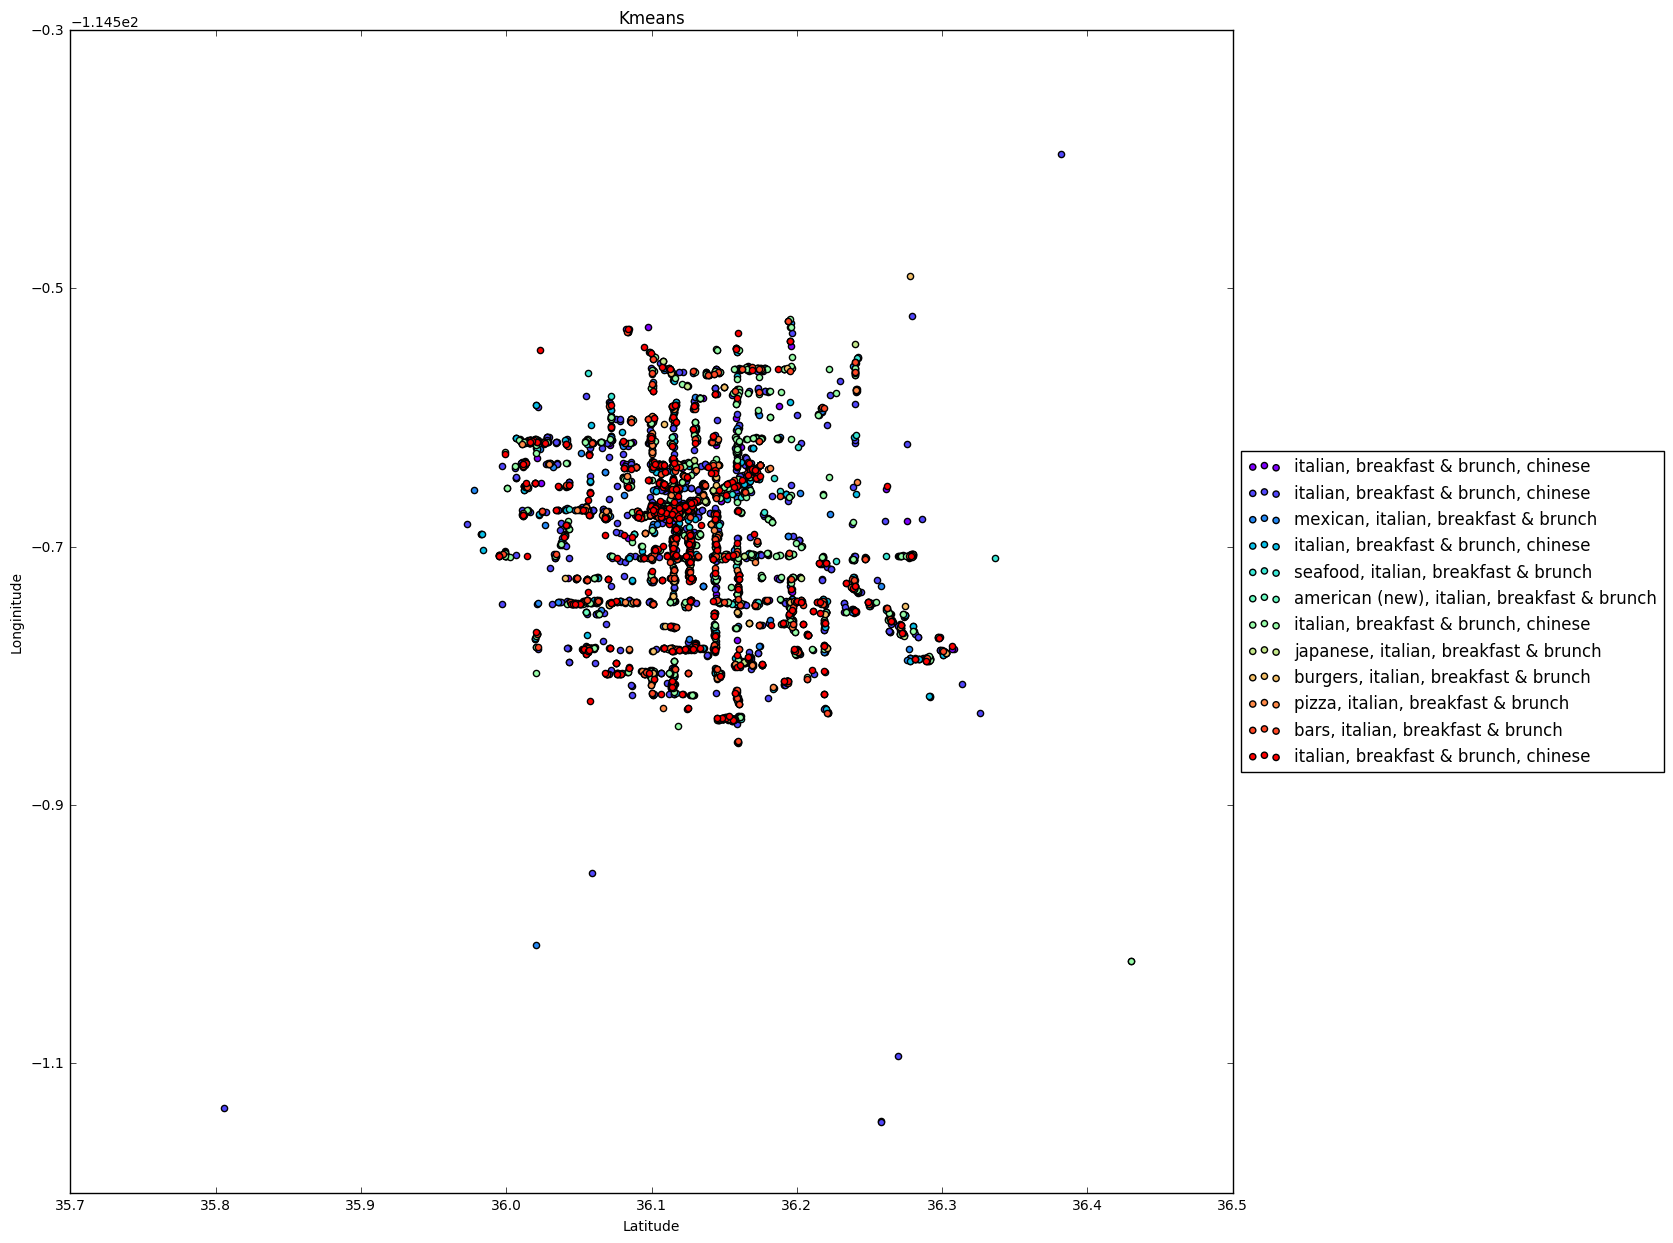

In [11]:
#Using the Silhouete Score 12 clusters is the best choice for clustering
K = 12

kmeans = KMeans(init='k-means++', n_clusters=K, max_iter=300)
result = kmeans.fit_predict(mat)
asc_centroids=kmeans.cluster_centers_[:,-K:].argsort()[:,::-1]
fig1=plt.figure(figsize=(15,15))
colors = cm.rainbow(np.linspace(0, 1, K))
for k in range(K):
    plt.scatter(latitudes[result==k],longitudes[result==k],c=colors[k,:],
                label=top_16[asc_centroids[k,0]]+', '+top_16[asc_centroids[k,1]]+', '+ top_16[asc_centroids[k,2]]) 

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  
plt.title('Kmeans')
plt.xlabel('Latitude')
plt.ylabel('Longinitude')
plt.show()

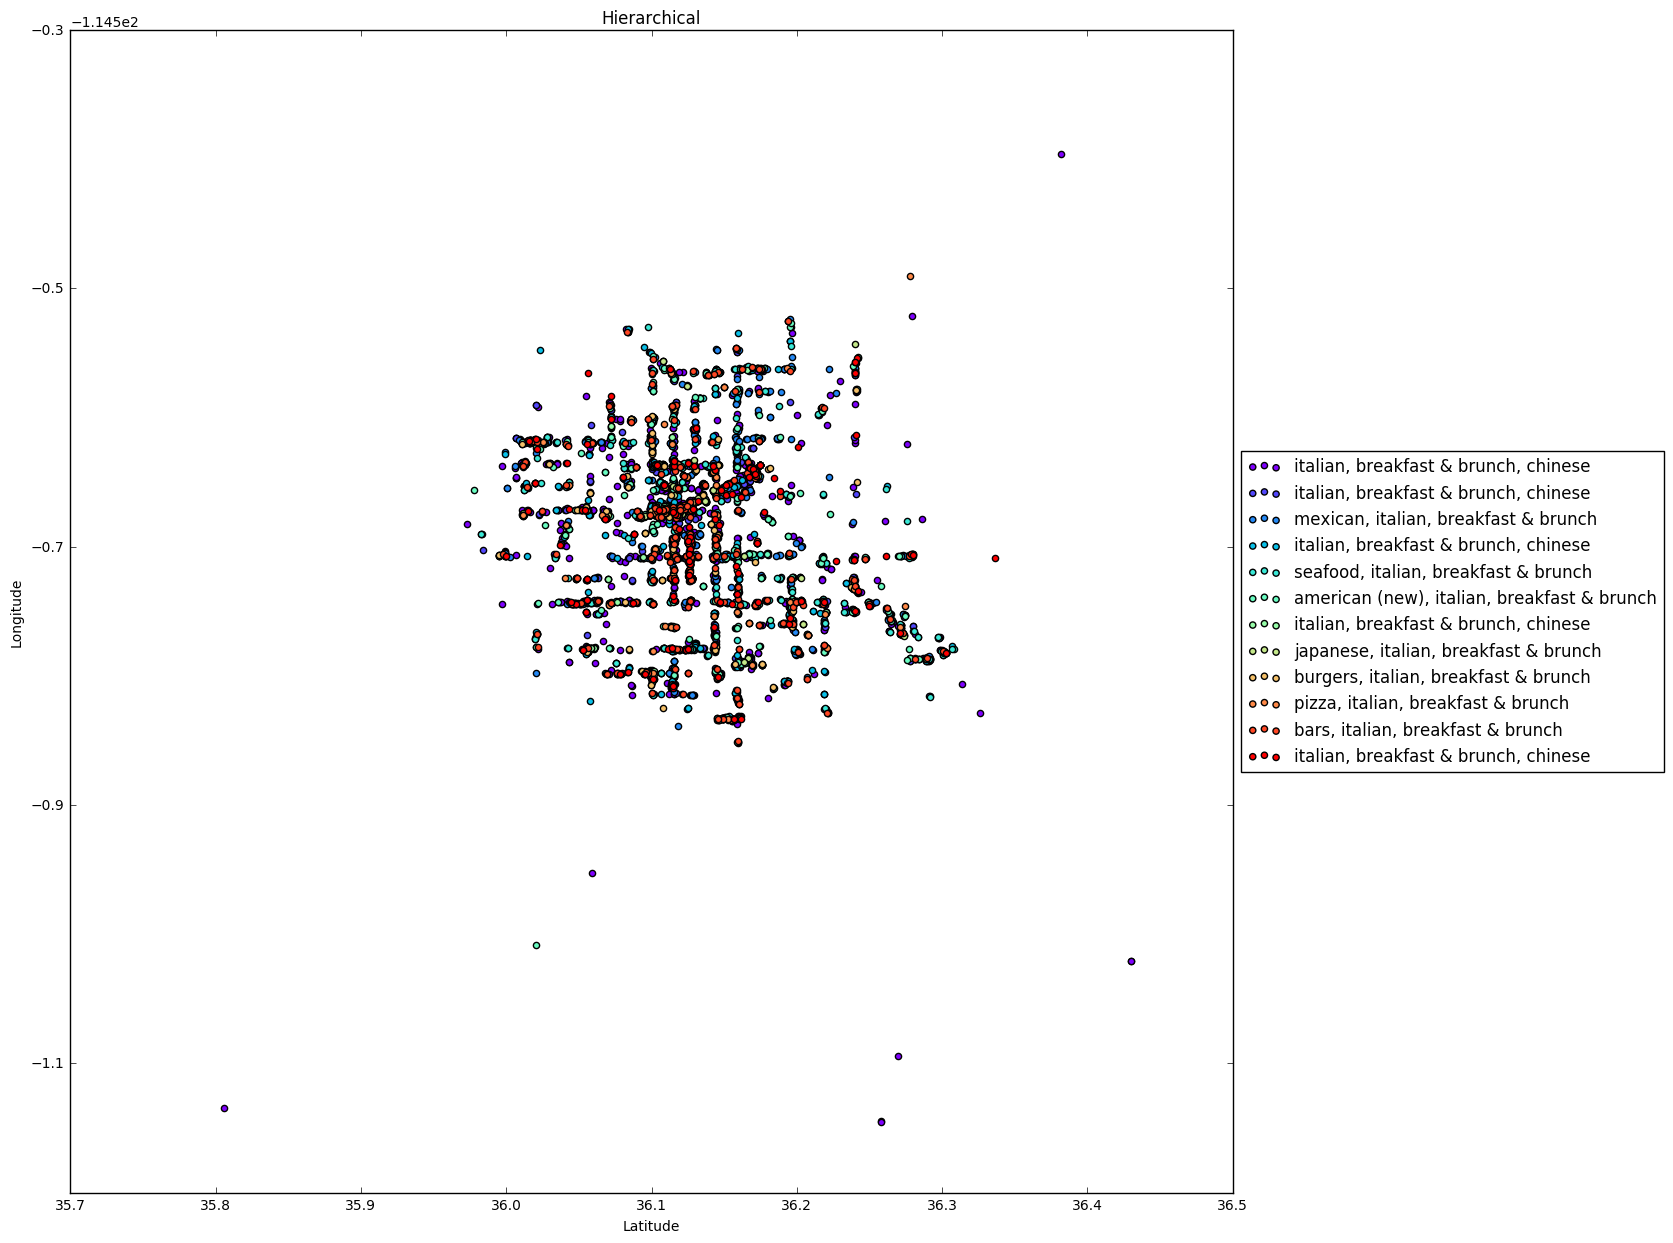

In [12]:
#Using the Silhouete Score 12 clusters is the best choice for clustering
K = 12

hier = AgglomerativeClustering(n_clusters=K)
result_1 = hier.fit_predict(mat)

fig1=plt.figure(figsize=(15,15))
colors = cm.rainbow(np.linspace(0, 1, K))


for k in range(K):
    kmean_h=KMeans(init='k-means++',n_clusters=1,max_iter=300)
    kmean_h.fit_predict(mat[result_1==k])
    asc_centroid=kmean_h.cluster_centers_[:,-K:].argsort()[:,::-1][0]
    plt.scatter(latitudes[result_1==k],longitudes[result_1==k],c=colors[k,:],
                label=top_16[asc_centroids[k,0]]+', '+top_16[asc_centroids[k,1]]+', '+ top_16[asc_centroids[k,2]]) 

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  
plt.title('Hierarchical')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

C:\Users\kasim\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:57: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\kasim\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\kasim\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\kasim\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:75: DeprecationWarning: Fun

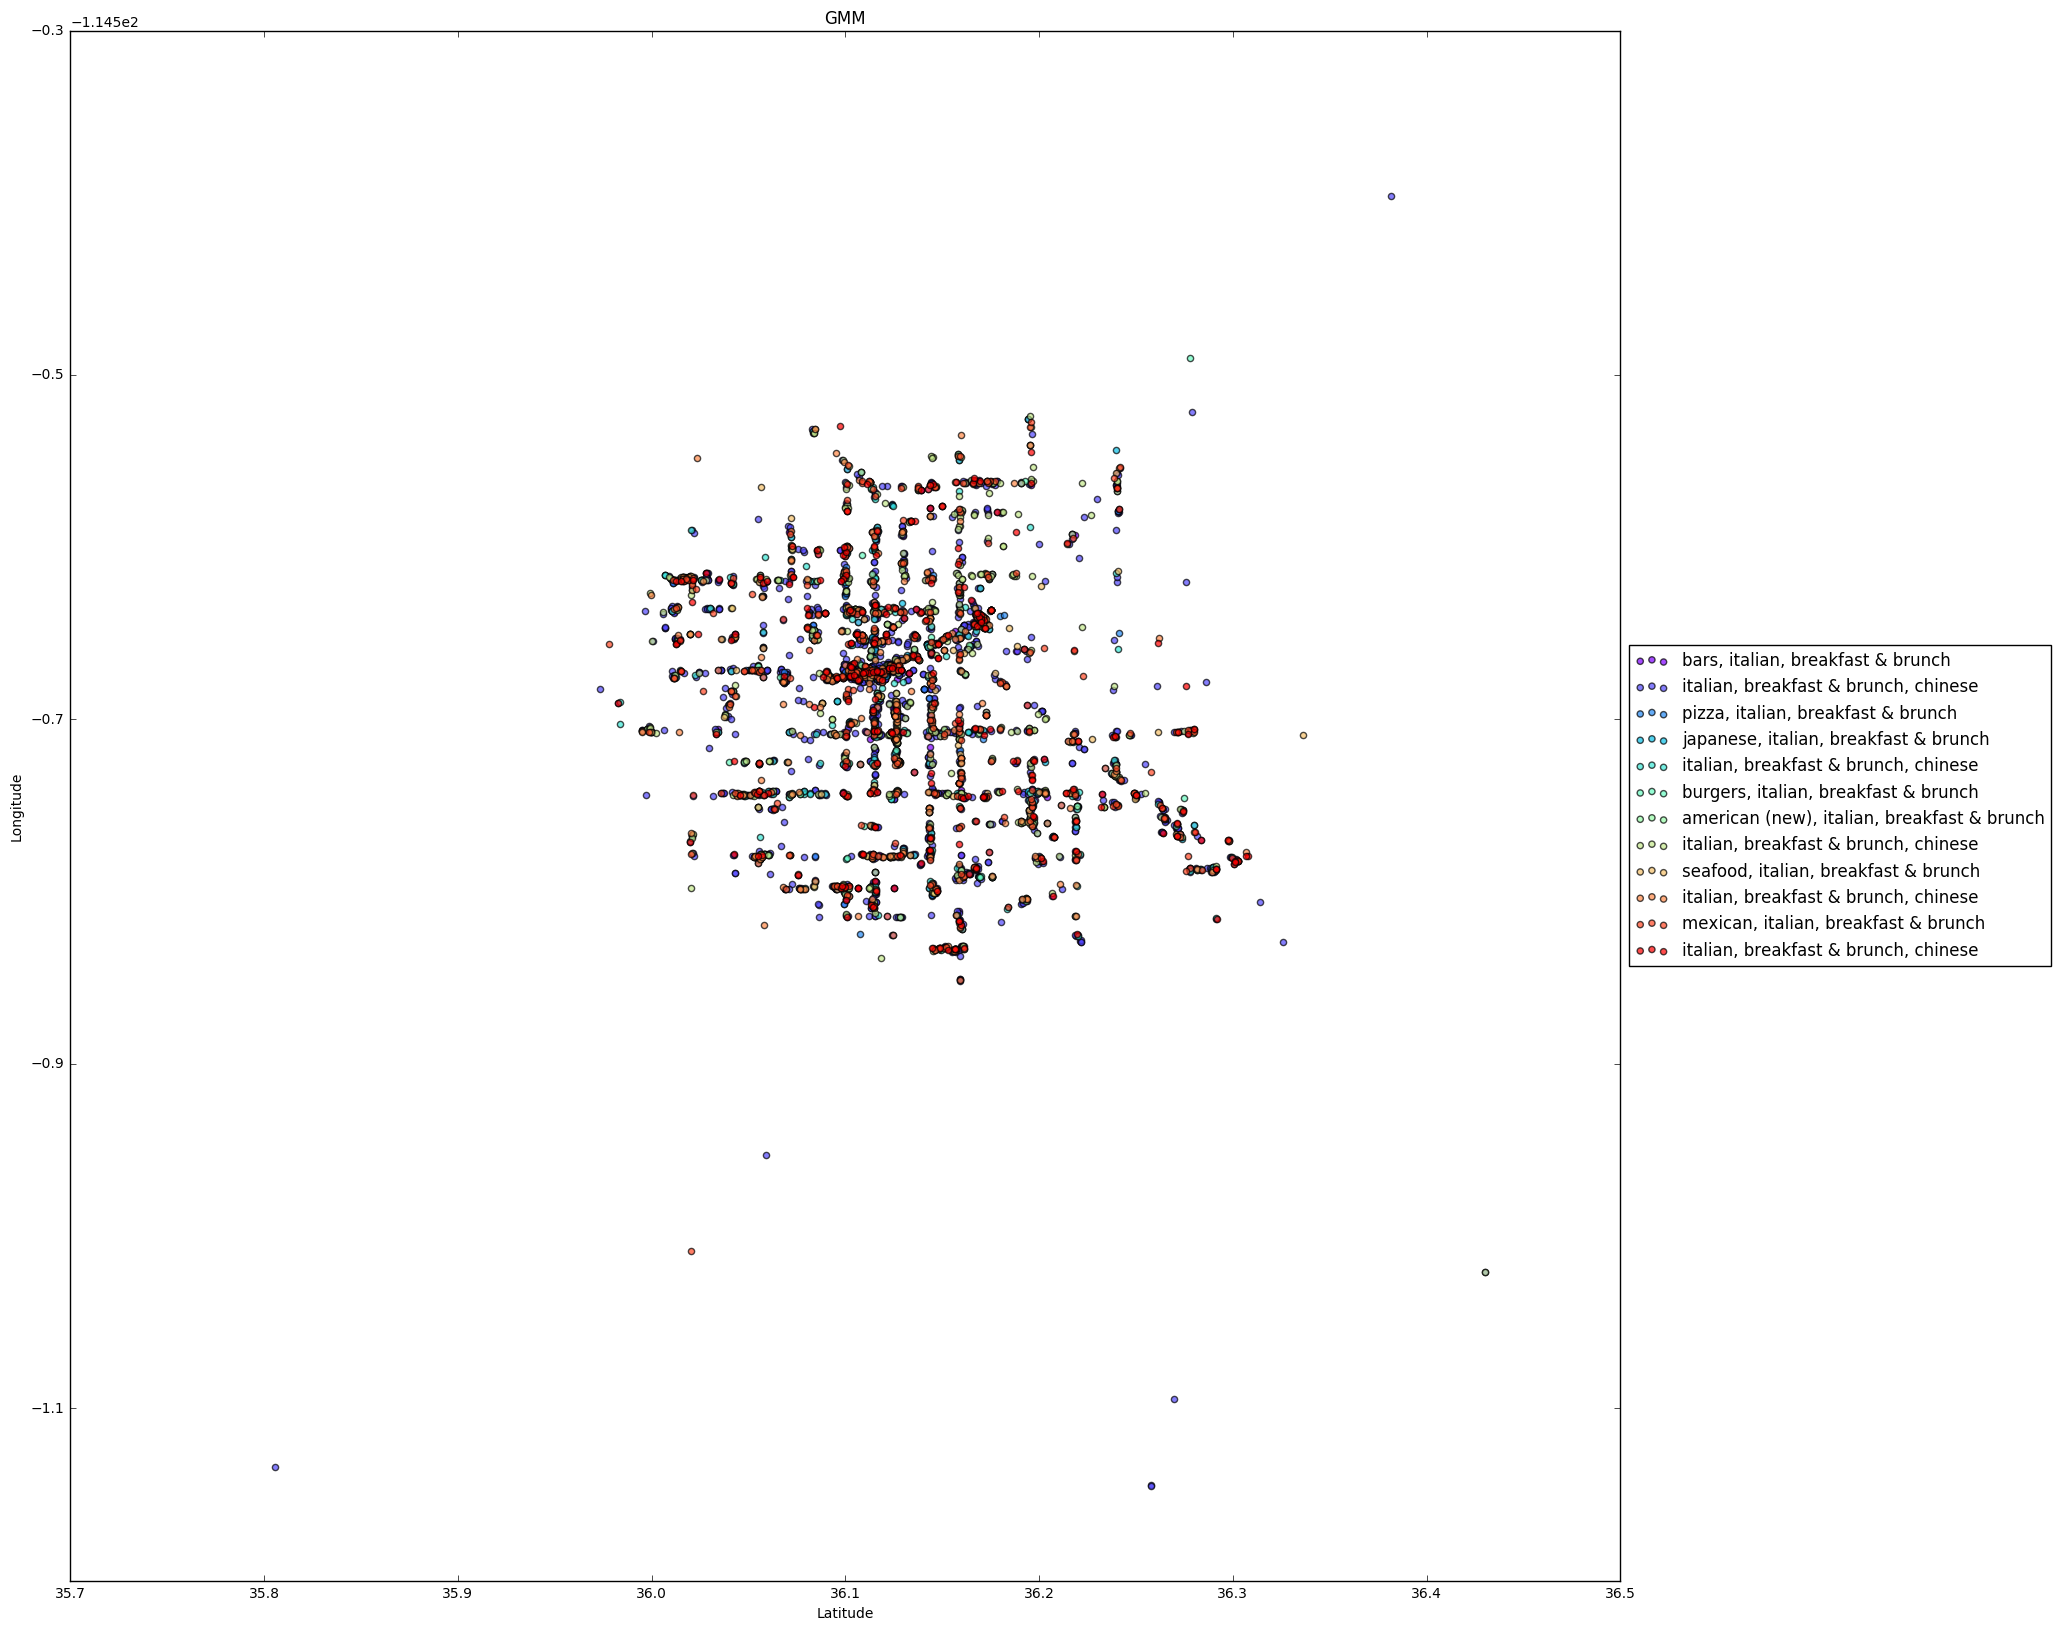

In [13]:
K = 12

Gmm=mixture.GMM(n_components=K,covariance_type='spherical')
result_2 = Gmm.fit_predict(mat)

fig1=plt.figure(figsize=(20,20))
colors = cm.rainbow(np.linspace(0, 1, K))


for k in range(K):
    kmean_gmm=KMeans(init='k-means++',n_clusters=1,max_iter=300)
    kmean_gmm.fit_predict(mat[result_2==k])
    asc_centroids_g=kmean_gmm.cluster_centers_[:,-K:].argsort()[:,::-1][0]
    plt.scatter(latitudes[result_2==k],longitudes[result_2==k],c=colors[k,:],alpha=0.7,
                label=top_16[asc_centroids_g[0]]+', '+top_16[asc_centroids_g[1]]+', '+ top_16[asc_centroids_g[2]]) 

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  
plt.title('GMM')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

How labels are assigned<br>

I rank the each cluster's representative by their coordinations, since the categories are vectorized ranging form 0 to 1, the higher number in a category means the cluster representative is more likely to belongs to that label

Visualize the clusters by plotting the longitude/latitude of the restaurants in a scatter plot. Label each cluster with a category. In a markdown, explain how labels are assigned. **(10 pts)**

Note that some categories are inherently more common (e.g. "pizza"). When labeling your clusters, you want to avoid the scenario where all clusters are labeled as "pizza" simply because of the uniformly large number of these restaurants across all clusters. In other words, we don’t want to point out that pizza restaurants are pretty much evenly distributed in high quantities everywhere, but rather discover when they, or another type of restaurant, appear in notably high quantities.

Now let's detect outliers. These are the ones who are the farthest from the centroids of their clusters. Track them down and describe any interesting observations that you can make. **(10 pts)**

In [18]:
print('Outliers:')

for i in range(12):
    a = mat[result==i][np.argmax(pairdist(mat[result==i],kmeans.cluster_centers_[i].reshape(1, -1)))][-15:].argsort()[-3:][::-1]
    b = mat[result_1==i][np.argmax(pairdist(mat[result_1==i],kmeans.cluster_centers_[i].reshape(1, -1)))][-15:].argsort()[-3:][::-1]
    c = mat[result_2==i][np.argmax(pairdist(mat[result_2==i],kmeans.cluster_centers_[i].reshape(1, -1)))][-15:].argsort()[-3:][::-1]
    print(top_16[a[0]]+','+ top_16[a[1]]+','+ top_16[a[2]]);
    print(top_16[b[0]]+','+ top_16[b[1]]+','+ top_16[b[2]]);
    print(top_16[c[0]]+','+ top_16[c[1]]+','+ top_16[c[2]]);

Outliers:
bars,asian fusion,seafood
asian fusion,seafood,japanese
american (new),asian fusion,seafood
asian fusion,seafood,japanese
mexican,asian fusion,seafood
asian fusion,seafood,japanese
pizza,asian fusion,seafood
asian fusion,seafood,japanese
chinese,asian fusion,seafood
mexican,asian fusion,seafood
american (traditional),asian fusion,seafood
sushi bars,asian fusion,seafood
chicken wings,asian fusion,seafood
bars,asian fusion,seafood
mexican,asian fusion,seafood
breakfast & brunch,asian fusion,seafood
pizza,asian fusion,seafood
italian,asian fusion,seafood
asian fusion,seafood,japanese
breakfast & brunch,asian fusion,seafood
breakfast & brunch,asian fusion,seafood
sushi bars,asian fusion,seafood
sushi bars,asian fusion,seafood
asian fusion,seafood,japanese
italian,asian fusion,seafood
chinese,asian fusion,seafood
chicken wings,asian fusion,seafood
chinese,asian fusion,seafood
italian,asian fusion,seafood
american (traditional),asian fusion,seafood
american (new),asian fusion,seafo

Give a detailed analysis comparing the results you obtained from the 3 techniques. **(10 pts)**

1) According to Silhouete score and the error in k means the optimum number of clusters are 12 in all three methods. <br>
2) K means outperforms the other two clustering mehtods. <br>
3) In Hierachical clustering if number of clusters is changed, you don't need to rerun the clustering again, since it has a tree-like structure. <br>
4) 

----------